In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "cassandra"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 36
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,0,1,0.839080,0.663636,0.741117,0.830101,0.748601,0.863864,0.844444,base
1,cassandra,0,2,0.731707,0.612245,0.666667,0.783013,0.692959,0.782418,0.784314,base
2,cassandra,0,3,0.781609,0.629630,0.697436,0.800272,0.706822,0.831402,0.793478,base
3,cassandra,0,4,0.686567,0.522727,0.593548,0.743506,0.651702,0.674627,0.812500,base
4,cassandra,0,5,0.742424,0.532609,0.620253,0.765046,0.669905,0.761462,0.842593,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.679487,0.646341,0.662500,0.775992,0.713726,0.725365,0.788136,ecoselekt
1,cassandra,15,17,0.679012,0.714286,0.696203,0.799810,0.750532,0.680637,0.788618,ecoselekt
2,cassandra,15,18,0.750000,0.814815,0.781065,0.876439,0.814970,0.840506,0.815126,ecoselekt
3,cassandra,15,19,0.710843,0.702381,0.706587,0.826047,0.746365,0.797970,0.793103,ecoselekt
4,cassandra,15,20,0.712329,0.787879,0.748201,0.871947,0.815111,0.766773,0.843284,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.850746,0.695122,0.765101,0.872106,0.797630,0.868246,0.915254,best
1,cassandra,15,17,0.865672,0.753247,0.805556,0.905290,0.835542,0.876674,0.926829,best
2,cassandra,15,18,0.916667,0.814815,0.862745,0.955545,0.879620,0.947428,0.949580,best
3,cassandra,15,19,0.925373,0.738095,0.821192,0.920874,0.840405,0.910070,0.956897,best
4,cassandra,15,20,0.870968,0.818182,0.843750,0.944595,0.877118,0.914525,0.940299,best


(420, 11)


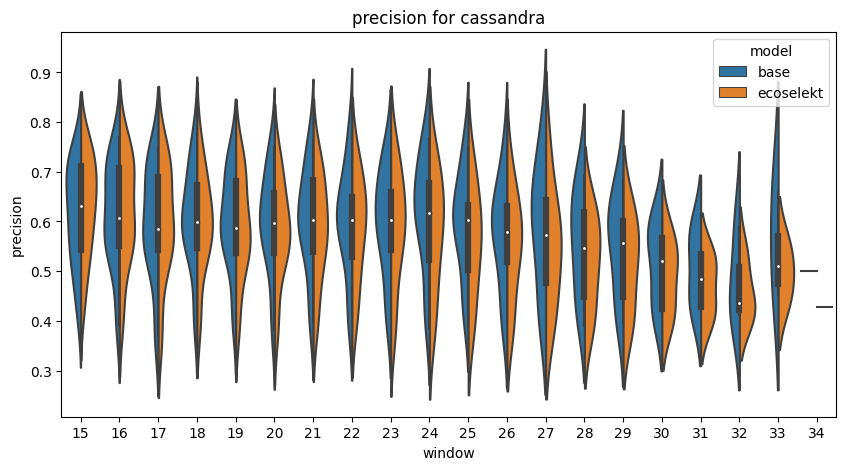

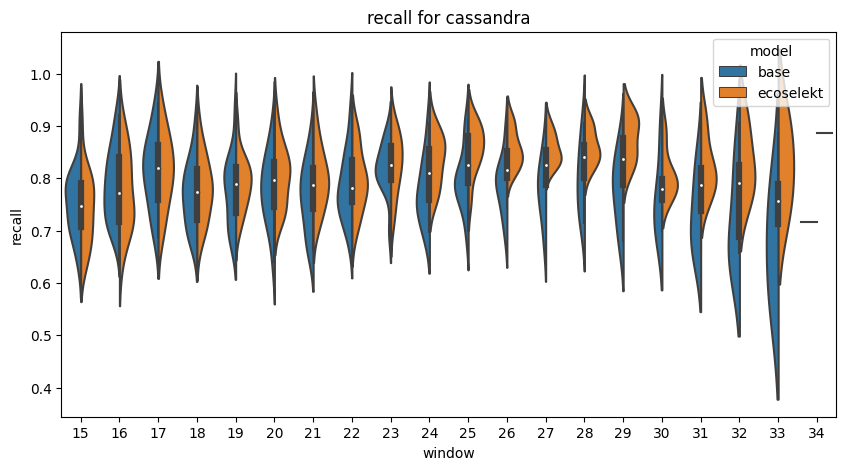

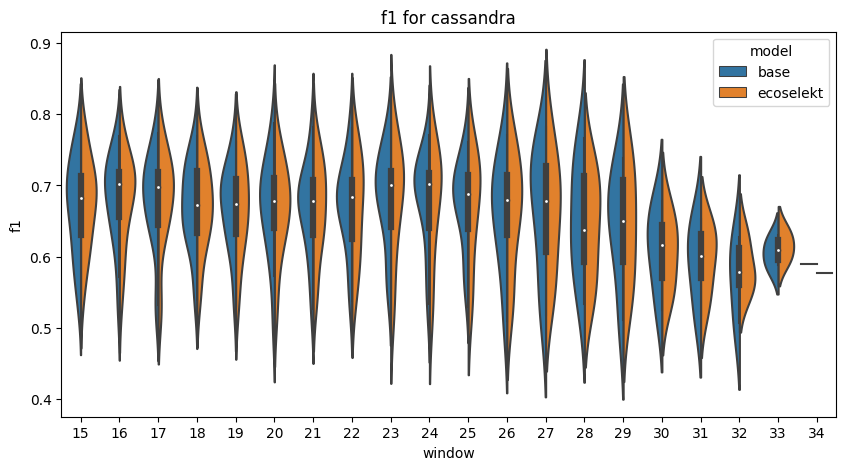

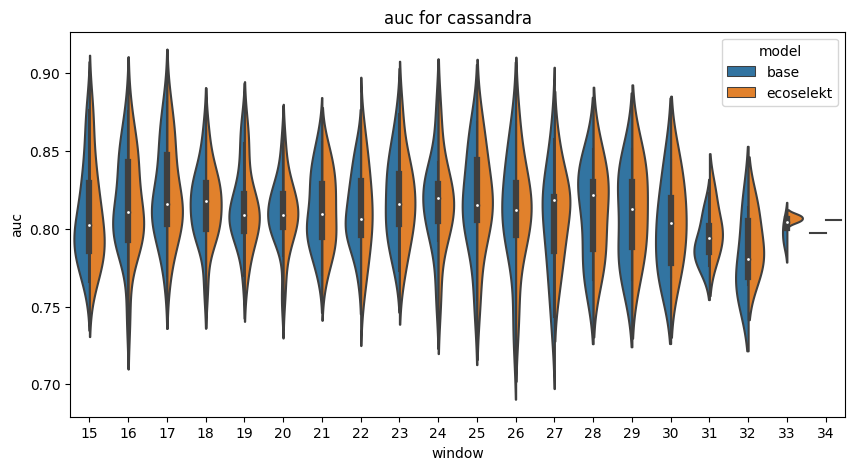

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


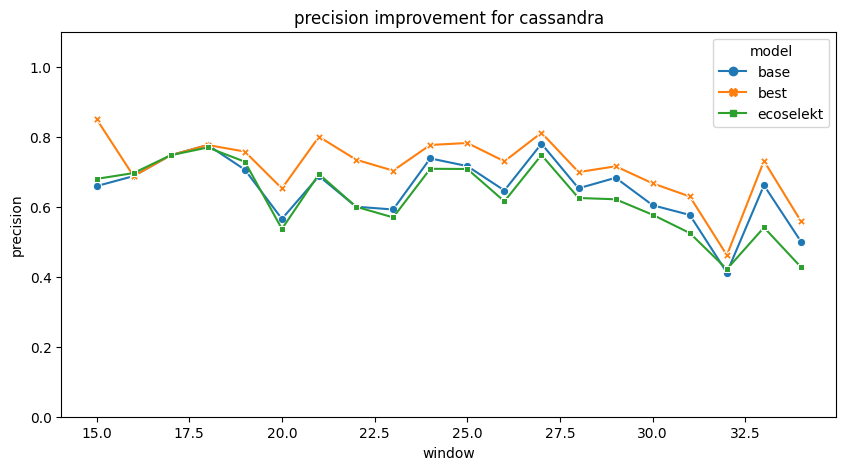

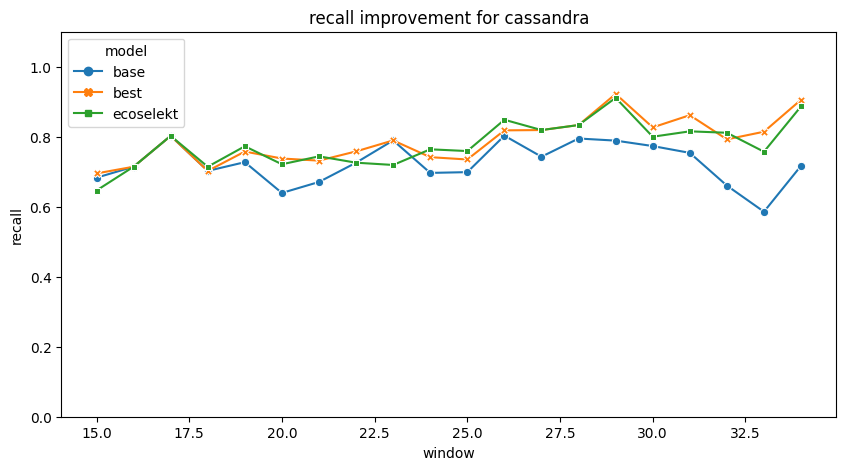

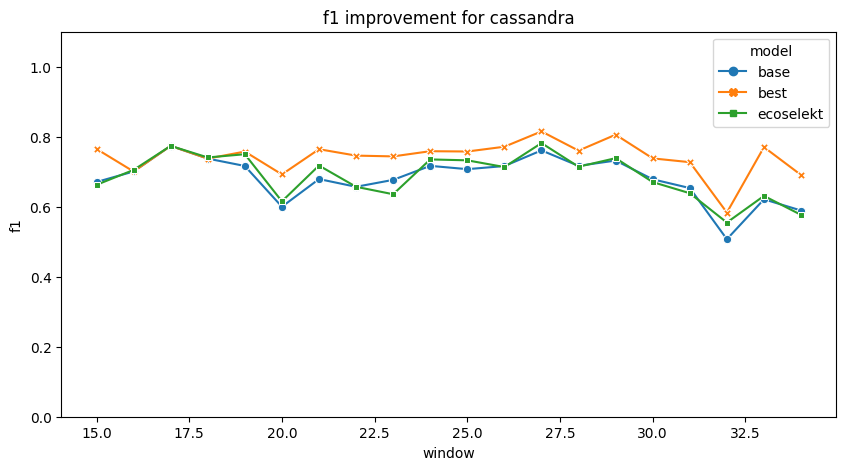

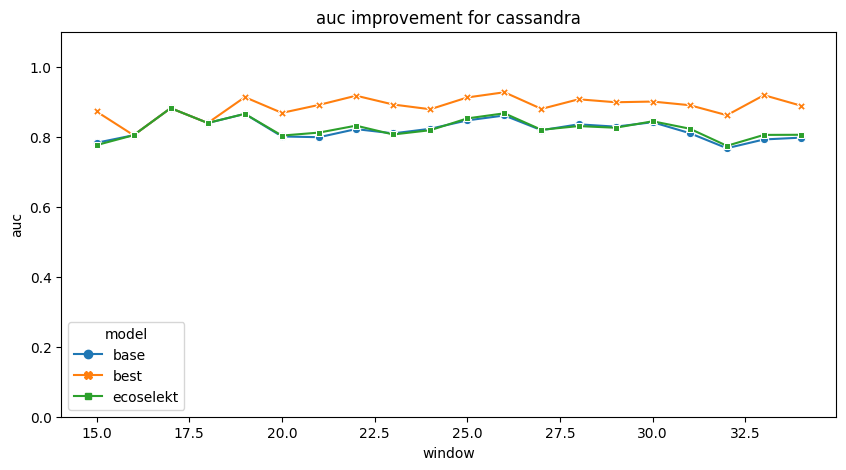

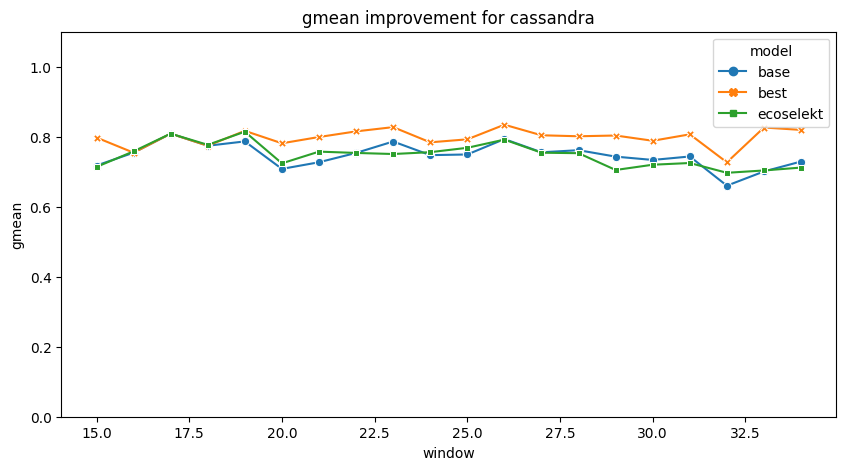

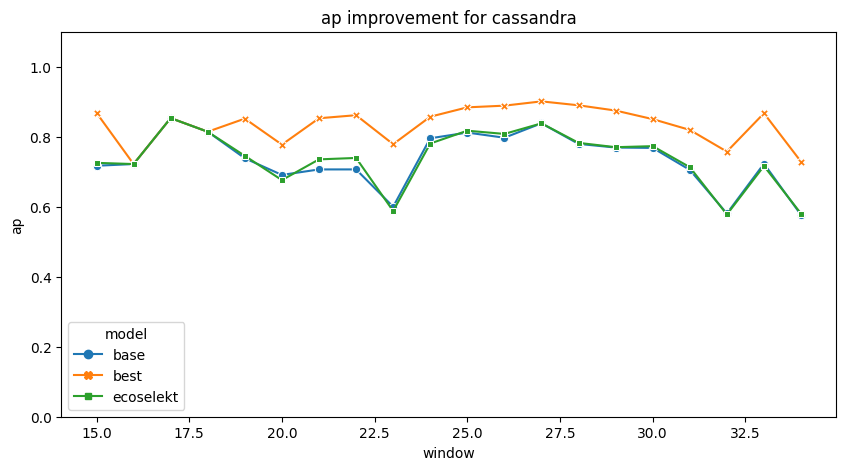

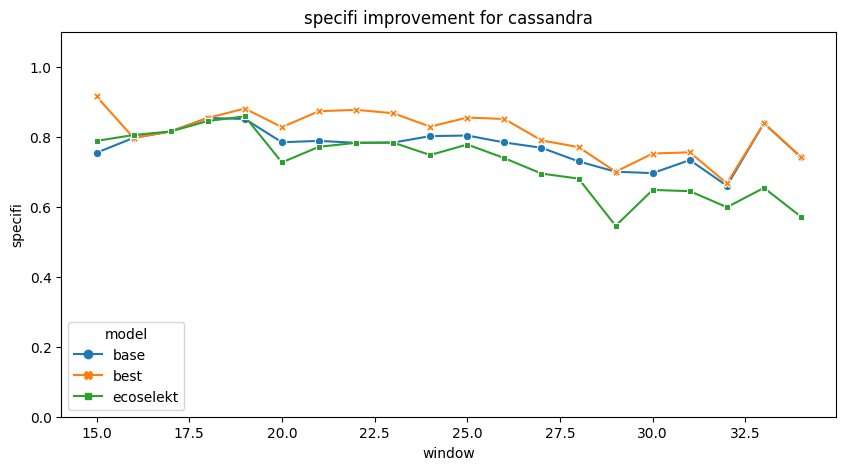

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

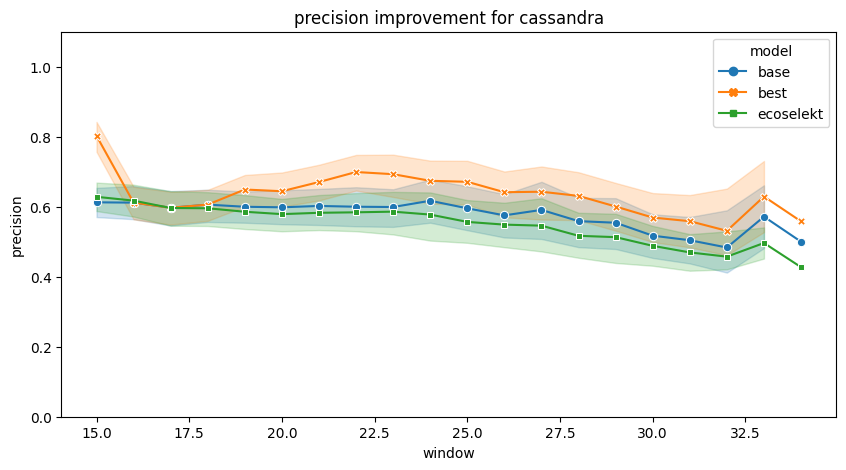

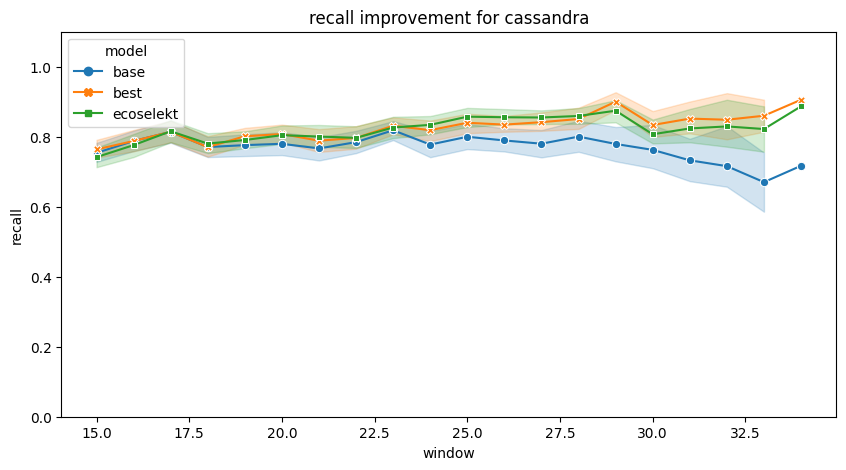

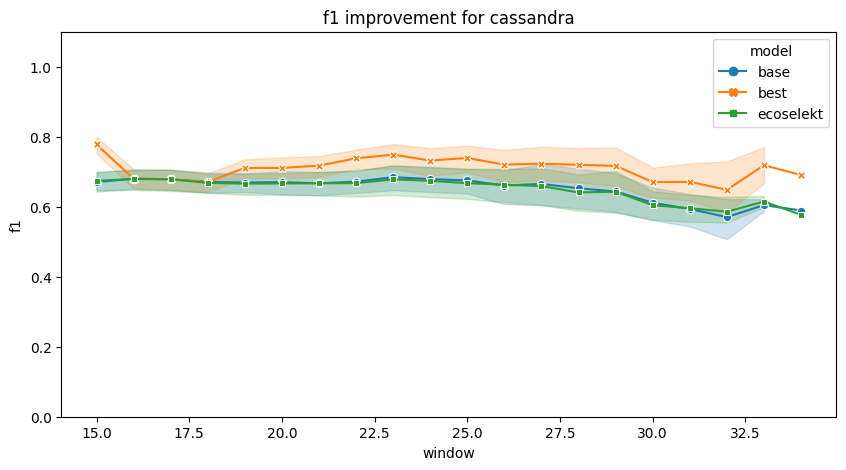

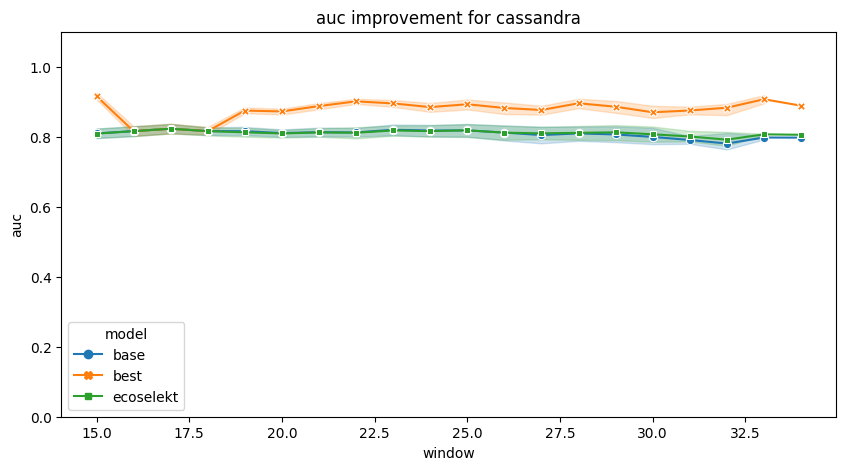

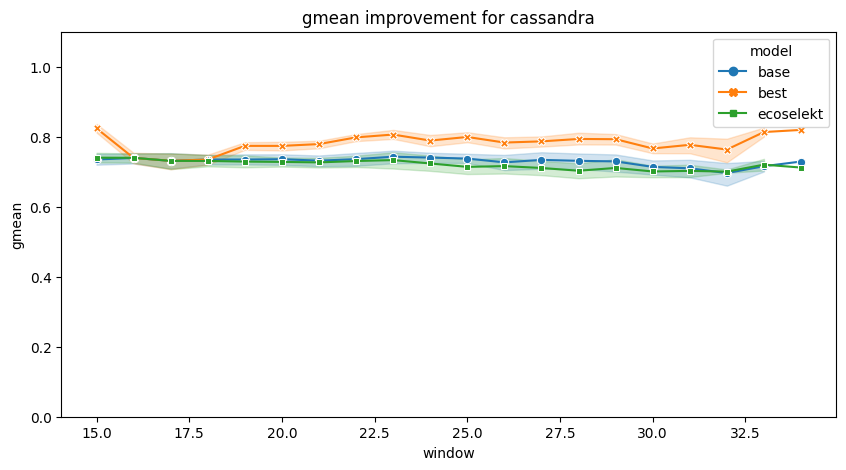

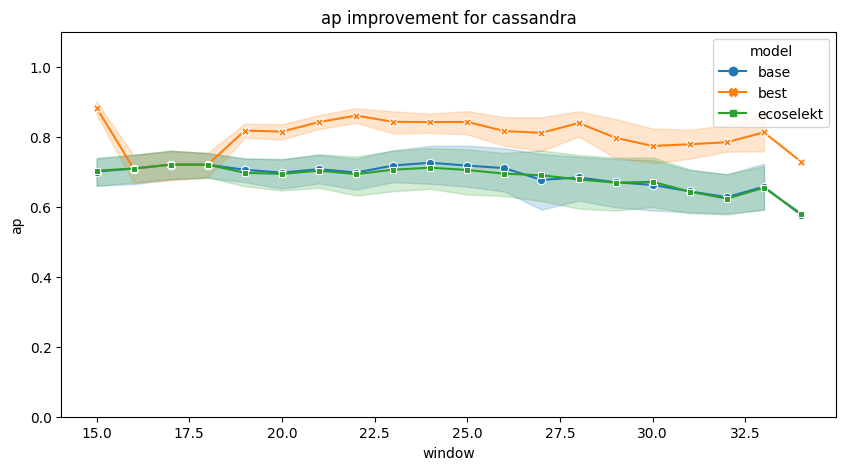

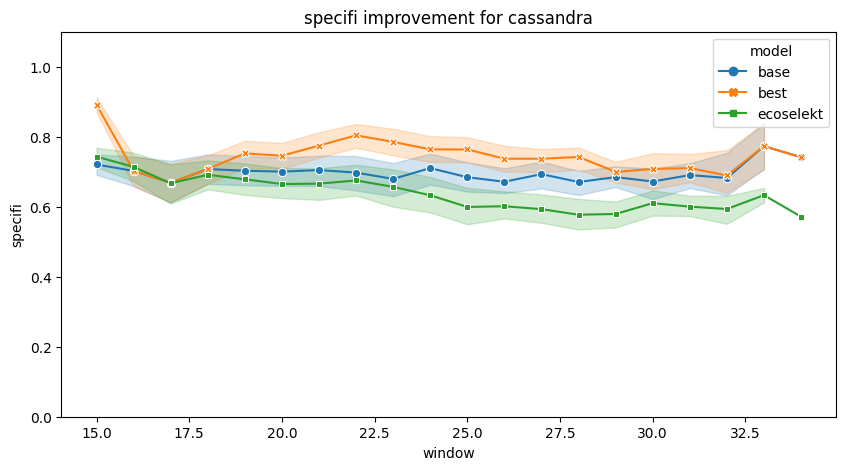

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.06418536322763828
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.0026473530335901696
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(42000, 4)


,commit_id,window,test_split,model_version
0,aef01d1627a4ed303da76f751c7c8c98418e6d45,15,16,0
1,b1abbf2d05d8cdf46c08a7a6e5289c9ade98dd3b,15,16,0
2,89e250b8b347876a5c9f74e738e182b66495d61b,15,16,0
3,c2812f38a4eea8124786e3753c4e45a7e07a9fd1,15,16,0
4,fc1daa3a7fb7328c70b3f07e3234f129ddfa56af,15,16,0


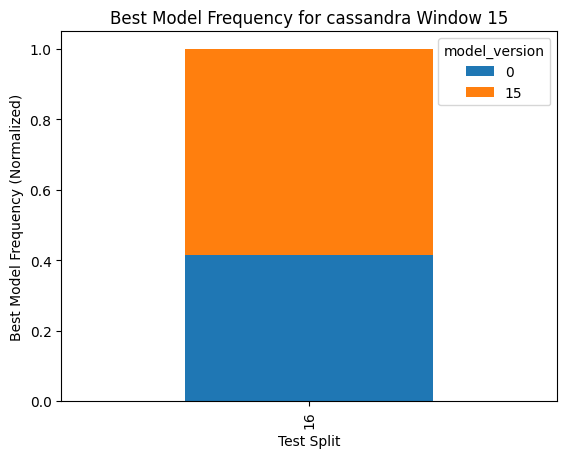

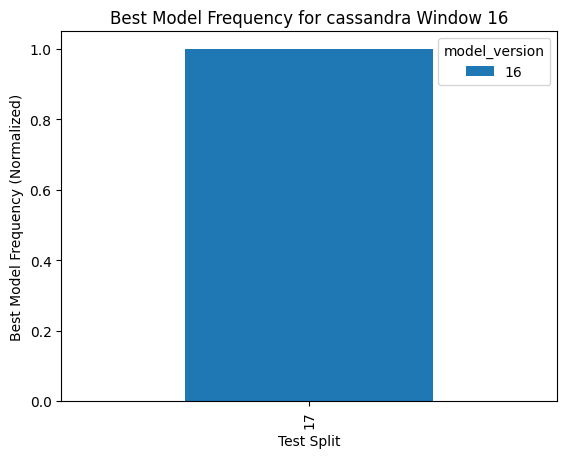

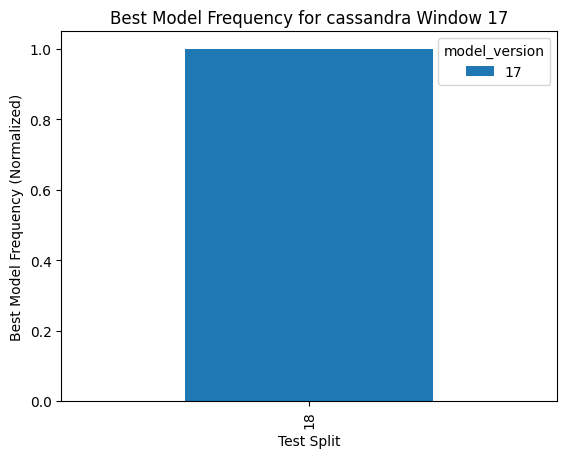

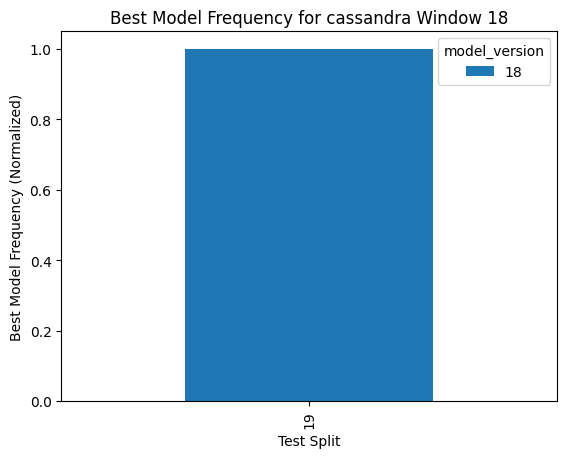

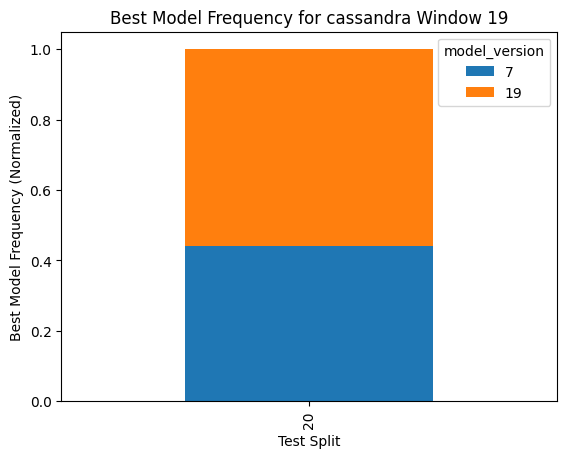

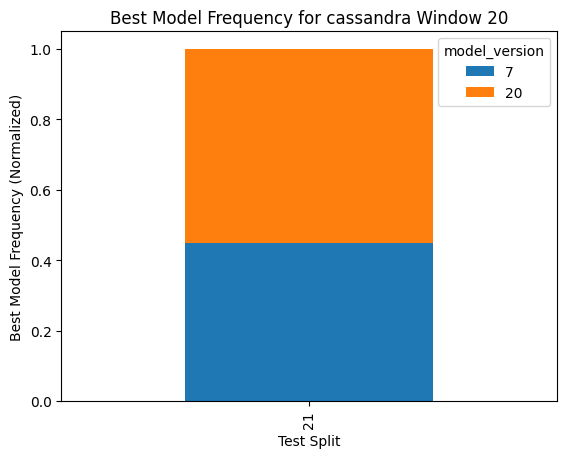

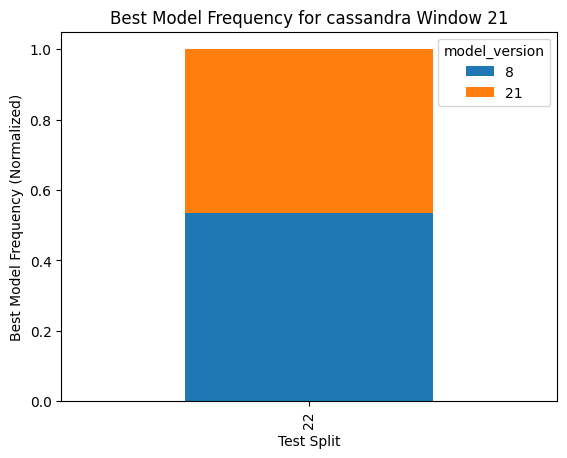

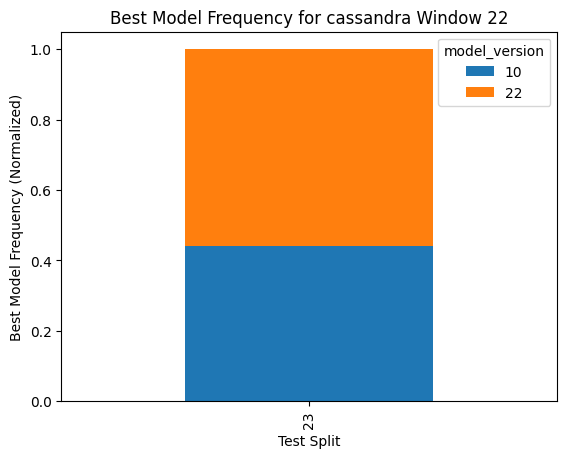

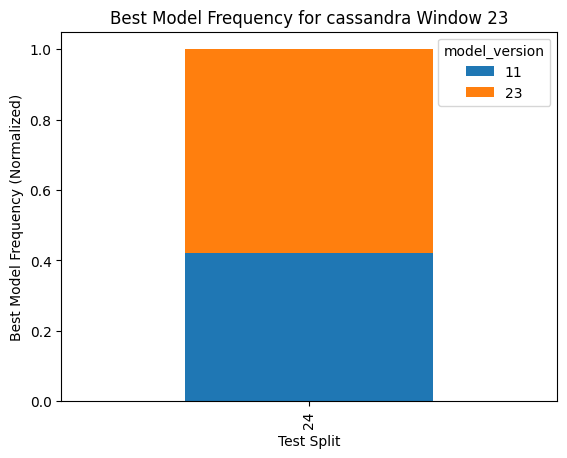

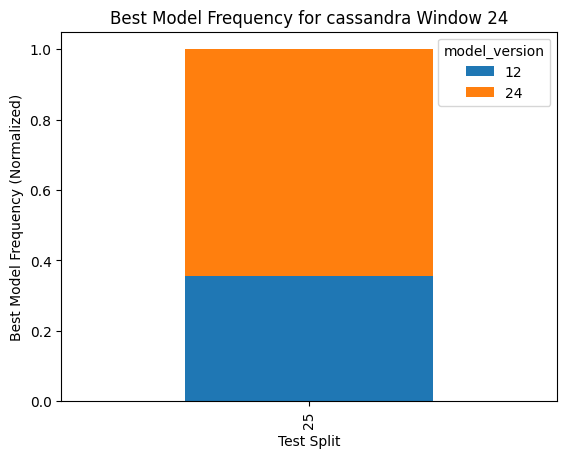

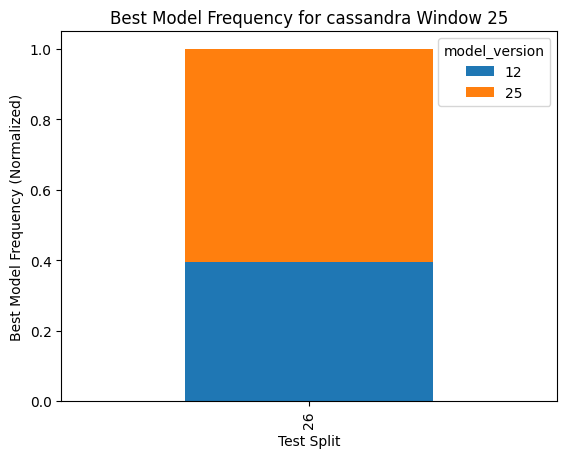

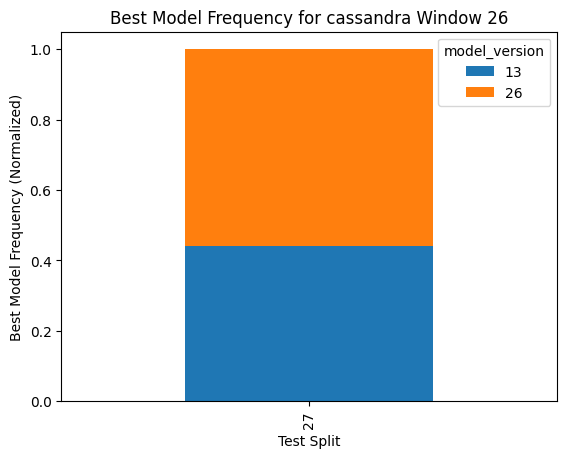

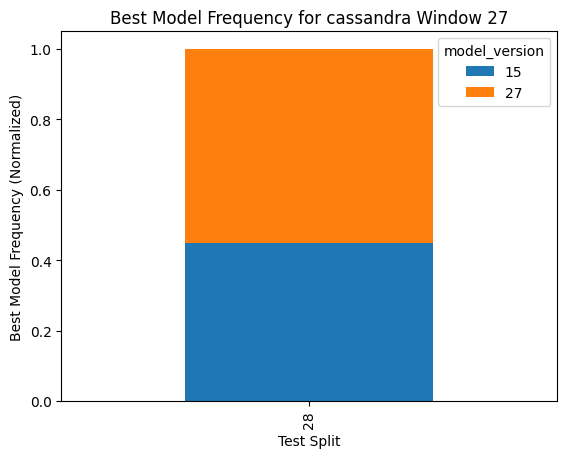

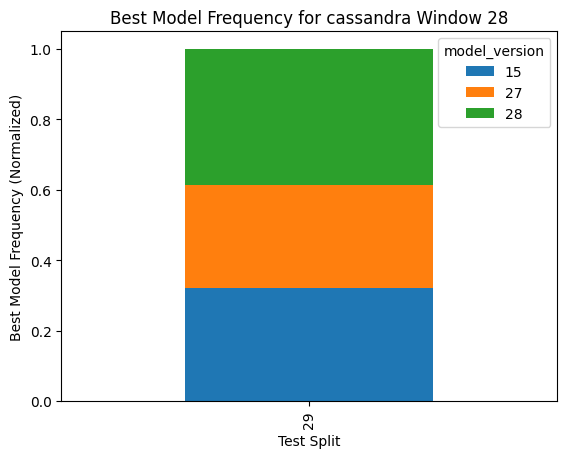

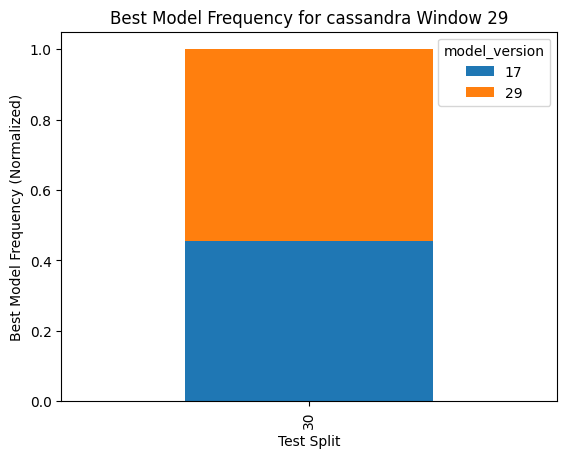

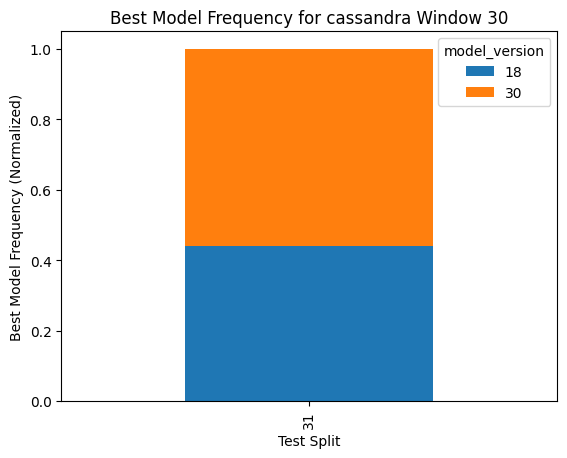

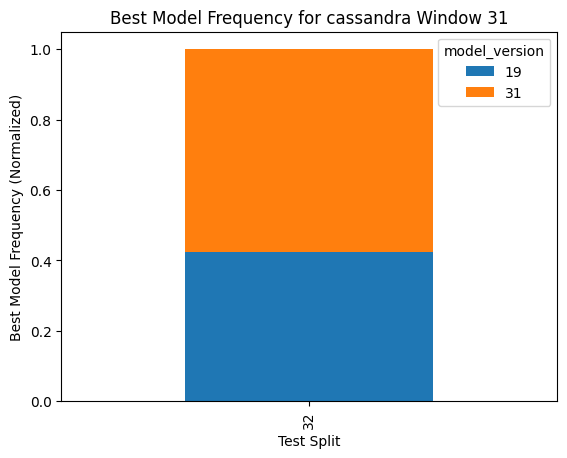

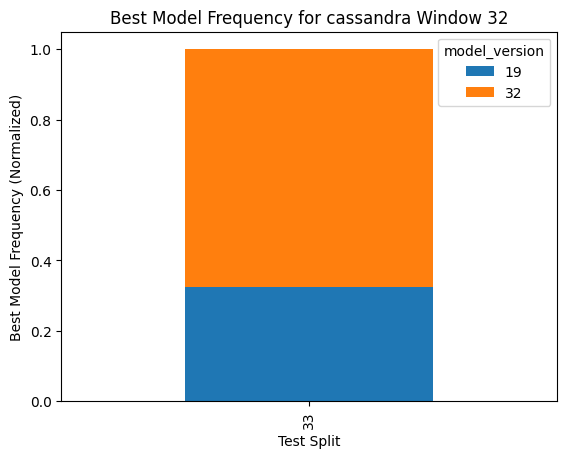

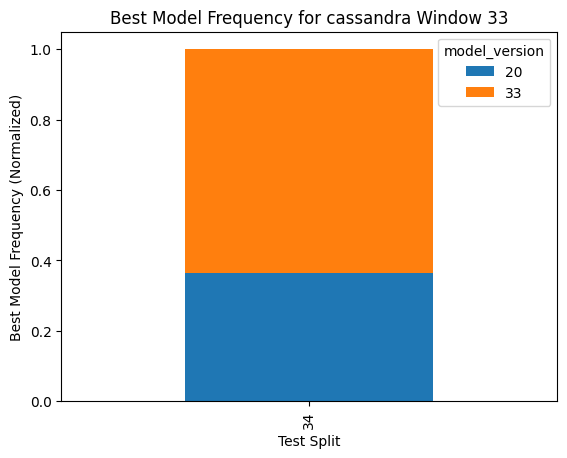

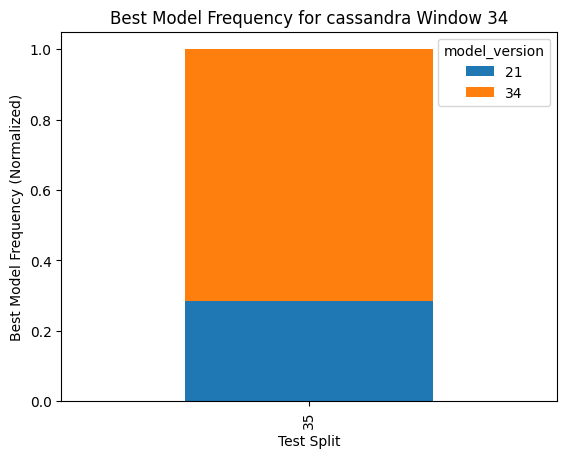

In [12]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")
    plt.show()